In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [8]:
# 1. 生成数据集
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 创建输入特征, 每个元素服从均值为0、标准差为1的正态分布, 形状为(num_examples, len(w))
    y = torch.matmul(X, w) + b # 计算线性回归的标签
    y += torch.normal(0, 0.01, y.shape) # 加点噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features, labels

(tensor([[-0.4586, -0.1583],
         [-1.6376,  0.5964],
         [-0.6330, -0.4928],
         ...,
         [-1.5285,  0.6014],
         [ 0.5090, -0.5890],
         [ 1.5245, -0.1452]]),
 tensor([[ 3.8219e+00],
         [-1.1064e+00],
         [ 4.6045e+00],
         [ 1.1215e+01],
         [ 4.7470e+00],
         [ 3.8380e+00],
         [ 6.8871e+00],
         [ 6.5405e-01],
         [ 5.5076e+00],
         [ 5.9535e+00],
         [ 6.7733e+00],
         [-8.7652e-01],
         [ 1.4665e+00],
         [-7.6414e+00],
         [ 1.1510e+00],
         [ 1.8941e+00],
         [-5.8139e+00],
         [ 3.6288e+00],
         [ 4.4115e+00],
         [ 5.4972e+00],
         [ 5.1915e+00],
         [ 4.3777e+00],
         [ 6.6117e-01],
         [ 7.0540e+00],
         [ 3.6984e+00],
         [ 1.8525e+00],
         [ 7.0602e+00],
         [ 4.9375e+00],
         [ 4.4329e+00],
         [-2.6660e+00],
         [ 2.1842e+00],
         [ 2.5479e+00],
         [ 9.4243e+00],
         [ 9.9920e

In [9]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.4586, -0.1583]) 
label: tensor([3.8219])


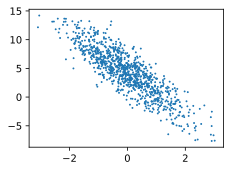

In [10]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [11]:
# 2. 读取数据
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 为所有样本创建一个索引列表
    random.shuffle(indices) # 打乱这个列表，使得可以随机读取

    # 迭代获取每一个小批量样本
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [12]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.3620,  0.5813],
        [-0.6864, -1.6034],
        [ 0.3831,  0.1970],
        [ 1.0391, -0.8449],
        [-0.0469,  1.0218],
        [-0.1466, -2.3479],
        [ 1.6745,  1.2795],
        [-0.5370, -1.5741],
        [ 0.5345, -0.5717],
        [ 0.1705, -0.2594]]) 
 tensor([[ 4.9321],
        [ 8.2804],
        [ 4.3011],
        [ 9.1589],
        [ 0.6257],
        [11.9000],
        [ 3.2058],
        [ 8.4624],
        [ 7.1981],
        [ 5.4271]])


In [15]:
# 3. 初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0005],
         [-0.0008]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [16]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [17]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [24]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [33]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss


for epoch in range(num_epochs):
    i = 0
    for X, y in data_iter(batch_size, features, labels):
        i += 1
        l = loss(net(X, w, b), y)  # 线性回归模型的预测值与真实值的损失
        # 总梯度的方向 = 所有样本梯度方向的叠加。
        # l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数

    # 接下来计算当前epoch下整个数据集的Loss只是为了打印日志看看情况，不要记录梯度图，也不要计算导数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


关于上述代码中为什么要用l.sum().backward()来计算梯度，而不是直接用l.backward()，原因如下：
1. l是一个张量，包含了每个样本的损失值。如果直接调用l.backward()，PyTorch会尝试计算每个样本损失对参数的梯度，这在大多数情况下是不需要的。
2. 在训练过程中，我们通常关心的是整个批次的总损失对参数的梯度。因此，我们需要将l中的所有元素加起来，得到一个标量总损失，然后对这个标量调用backward()，以计算参数的梯度。
### 至于为什么是 Sum 而不是别的？(深层理解)
让我们从链式法则的源头看。
如果我们写成通用形式：$L = \text{Op}(l_1, l_2)$ （Op 是某种操作，比如 sum 或 mean）。 \
链式法则完整写法是：$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial l_1} \cdot \frac{\partial l_1}{\partial w} + \frac{\partial L}{\partial l_2} \cdot \frac{\partial l_2}{\partial w}$$
如果使用 sum(): $L = l_1 + l_2$，那么 $\frac{\partial L}{\partial l_1} = 1$，$\frac{\partial L}{\partial l_2} = 1$。这相当于给每个样本的梯度赋予了 $1.0$ 的权重。\
如果使用 mean(): $L = \frac{l_1 + l_2}{2} = 0.5 l_1 + 0.5 l_2$，那么 $\frac{\partial L}{\partial l_1} = 0.5$，$\frac{\partial L}{\partial l_2} = 0.5$。这相当于把算出来的梯度都除了 2。


In [34]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0001, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
